<a href="https://colab.research.google.com/github/oonya/image-processing/blob/master/Kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kmeansに関するコード群

- labでKmeansをする
  - クラスタに対し最大のSaturationやValueをとったり、meansをとる

- 普通のKmeansに対しSaturationの高いpixelをとる
  - 上位1000ピクセルの平均や最頻値
  - それらに対しどこかでガンマ補正をかけてやる

contours 6
21.0


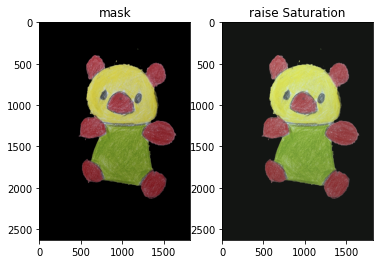

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def white_balance(img):
    result = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    avg_a = np.average(result[:, :, 1])
    avg_b = np.average(result[:, :, 2])
    result[:, :, 1] = result[:, :, 1] - ((avg_a - 128) * (result[:, :, 0] / 255.0) * 1.1)
    result[:, :, 2] = result[:, :, 2] - ((avg_b - 128) * (result[:, :, 0] / 255.0) * 1.1)
    result = cv2.cvtColor(result, cv2.COLOR_LAB2RGB)
    return result



def my_bin(img1):
  img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
  img1 = white_balance(img1)
  img1_g = cv2.cvtColor(img1, cv2.COLOR_RGB2HSV)[:, :, 1]
  ret, th = cv2.threshold(img1_g, 0, 255, cv2.THRESH_OTSU)
  kernel = np.ones((20, 20), np.uint8)
  mor = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel)
  return mor

img = cv2.imread('drive/My Drive/latest1.JPG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = white_balance(img)

mor = my_bin(img)

contours, hierarchy = cv2.findContours(mor, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print("contours",len(contours))

mask = np.zeros_like(img)
cv2.drawContours(mask, contours, -1, (255, 255, 255), -1)
mask = mask & img



def raiseSaturation(img):
    r = img[:,:,0].astype(np.float32)
    g = img[:,:,1].astype(np.float32)
    b = img[:,:,2].astype(np.float32)

    _max = np.max([255 - np.max(r),255 - np.max(g),255 - np.max(b)])
    print(_max)

    r = img[:, :, 0] + _max
    g = img[:, :, 1] + _max
    b = img[:, :, 2] + _max

    result = np.zeros(img.shape,dtype=float)
    result[:,:,0] =  r / np.max(r)
    result[:,:,0] *= 255
    result[:,:,1] =  g / np.max(g)
    result[:,:,1] *= 255
    result[:,:,2] =  b / np.max(b)
    result[:,:,2] *= 255
    return result.astype(np.uint8)

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.set_title('mask')
ax.imshow(mask)

ax = fig.add_subplot(1, 2, 2)
ax.set_title('raise Saturation')
ax.imshow(raiseSaturation(mask))

# mask = raiseSaturation(mask)

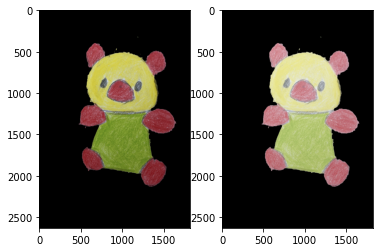

In [ ]:
# Kmeansにかける前処理

def gamma_correction(img):

  # gamma = 3.1 # gammaはパラメータで、1.0より大きいと明るく、小さいと暗くなる
  gamma = 2.2

  lookUpTable = np.zeros((256, 1), dtype = 'uint8')

  for i in range(256):
    lookUpTable[i][0] = 255 * pow(float(i) / 255, 1.0 / gamma)

  img_gamma = cv2.LUT(img, lookUpTable)

  return img_gamma

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(mask)

g_img = gamma_correction(mask)

ax = fig.add_subplot(1, 2, 2)
ax.imshow(g_img)

mask = g_img

0 mean [[[224 221 168]]]
0 Saturation [[[224 218 124]]]
0 Value [[[252 216 225]]]
1 mean [[[191 128 136]]]
1 Saturation [[[176  61  74]]]
1 Value [[[227 159 171]]]
2 mean [[[177 193 114]]]
2 Saturation [[[134 141  52]]]
2 Value [[[219 213 122]]]
(474141, 3)


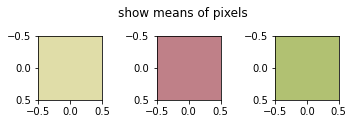

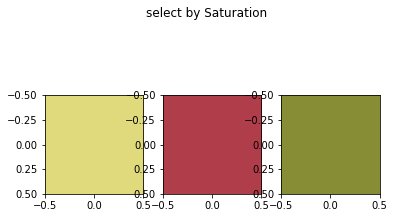

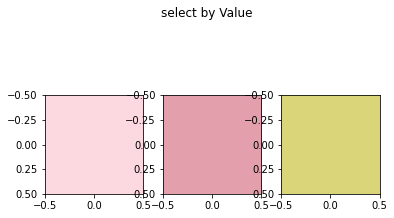

In [ ]:
# 普通にKmeans


from sklearn.cluster import KMeans

data = np.reshape(mask, (mask.shape[0]*mask.shape[1], mask.shape[2])) # クラスタリングのために2次元に直す

data = data[(data != 0).all(axis=1)]

n_clusters=3 # クラスタ数(何色に減色するか)
model = KMeans(n_clusters=n_clusters, random_state=10).fit(data)
labels = model.labels_



fig = plt.figure()
fig.suptitle("show means of pixels")

fig1 = plt.figure()
fig1.suptitle("select by Saturation")

fig2 = plt.figure()
fig2.suptitle("select by Value")





# maxSaturationIndex(data[labels==0, :])

for l in range(0,n_clusters):
    mean = np.mean(data[labels==l,:], axis=0)

    ax = fig.add_subplot(3, 3, l+1)
    ax.imshow(np.uint8([[mean]]))

    clusters = data[labels==l, :]
    # print(getMaxSaturationPixel(clusters))

    ax = fig1.add_subplot(1, 3, l+1)
    ax.imshow(np.uint8([[getMaxSaturationPixel(clusters)]]))

    ax = fig2.add_subplot(1, 3, l+1)
    ax.imshow(np.uint8([[getMaxValuePixel(clusters)]]))

    print(l, 'mean', np.uint8([[mean]]))
    print(l, 'Saturation', np.uint8([[getMaxSaturationPixel(clusters)]]))
    print(l, 'Value', np.uint8([[getMaxValuePixel(clusters)]]))

print(data[labels==0, :].shape)

[185  99 104]
[153 103 109]
[161 189 107]
(469418, 3)


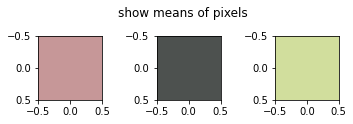

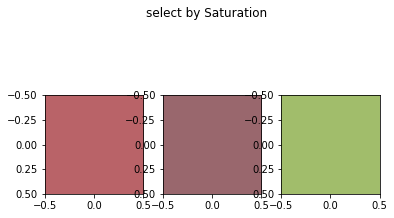

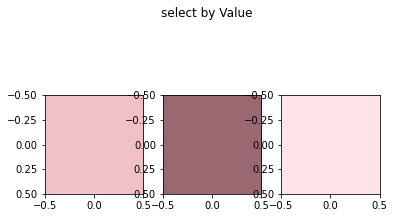

In [ ]:
# Labで2値化

from sklearn.cluster import KMeans

data = np.reshape(mask, (mask.shape[0]*mask.shape[1], mask.shape[2])) # クラスタリングのために2次元に直す

data = data[(data != 0).all(axis=1)]

lab_data = cv2.cvtColor(np.uint8([data]), cv2.COLOR_RGB2LAB)
data = lab_data[0]


n_clusters=3 # クラスタ数(何色に減色するか)
model = KMeans(n_clusters=n_clusters, random_state=10).fit(data)
labels = model.labels_

data = cv2.cvtColor(np.uint8([data]), cv2.COLOR_LAB2RGB)
data = data[0]


fig = plt.figure()
fig.suptitle("show means of pixels")

fig1 = plt.figure()
fig1.suptitle("select by Saturation")

fig2 = plt.figure()
fig2.suptitle("select by Value")





# maxSaturationIndex(data[labels==0, :])

for l in range(0,n_clusters):
    mean = np.mean(data[labels==l,:], axis=0)

    ax = fig.add_subplot(3, 3, l+1)
    ax.imshow(np.uint8([[mean]]))

    clusters = data[labels==l, :]
    print(getMaxSaturationPixel(clusters))

    ax = fig1.add_subplot(1, 3, l+1)
    ax.imshow(np.uint8([[getMaxSaturationPixel(clusters)]]))

    ax = fig2.add_subplot(1, 3, l+1)
    ax.imshow(np.uint8([[getMaxValuePixel(clusters)]]))

print(data[labels==0, :].shape)

In [ ]:
# functions
# MTG'code


def getMaxSaturationPixel(clusters):
  hsv_c = cv2.cvtColor(np.uint8([clusters]), cv2.COLOR_RGB2HSV)
  s = hsv_c[:, :, 1]
  return clusters[np.argmax(s[0])]

def getMaxValuePixel(clusters):
  hsv_c = cv2.cvtColor(np.uint8([clusters]), cv2.COLOR_RGB2HSV)
  s = hsv_c[:, :, 2]
  return clusters[np.argmax(s[0])]

def maxSaturationPixelAverage(clusters):
  hsv_c = cv2.cvtColor(np.uint8([clusters]), cv2.COLOR_RGB2HSV)
  s = hsv_c[:, :, 1][0] # shape = (417885, )

  # sort_index = np.argsort(-s)# argsort(s)で昇順、argsort(-s)で降順
  sort_index = np.argsort(s)[::-1] #こちらでもできるらしい（上は怪しい）
  
  high_saturation_pixels = []
  for i in range(0, 10):
    high_saturation_pixels.append(clusters[sort_index[i]])

  
  # print(high_saturation_pixels)

maxSaturationPixelAverage(data[labels==0, :])

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


rgb = np.uint8([[[0, 0, 0]]])
hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)

print(hsv)

[[[  0 128 128]]]
